In [1]:
import pandas as pd
import os

In [2]:
import random
import matplotlib.pyplot as plt
import collections
import numpy as np
import operator
import simpleclock
import sklearn.metrics
import itertools
import pickle
import tqdm

In [3]:
import torch
import torchtext

## Dataset, iterators

In [4]:
data_path = os.path.join(os.path.abspath(''), "data_cine_cleaned.csv")

In [5]:
TEXT = torchtext.data.Field(tokenize = "spacy",
                            tokenizer_language="fr_core_news_sm",
                            include_lengths=True)
LABEL = torchtext.data.LabelField(dtype=torch.float, use_vocab=False, preprocessing=lambda x: float(x) / 5)
# labels are linearly rescaled to a 0-1 range

In [6]:
dataset = torchtext.data.TabularDataset(path=data_path,
                                        format="CSV",
                                        fields={"critique": ("input", TEXT), "note": ("target", LABEL)})

In [7]:
data_train, data_test = dataset.split()

In [8]:
data_train, data_valid = data_train.split()

In [9]:
print(f"""training data: {len(data_train)} examples.
validation data: {len(data_valid)} examples.
test data: {len(data_test)} examples.""")

training data: 36057 examples.
validation data: 15453 examples.
test data: 22076 examples.


In [10]:
vectors = torchtext.vocab.Vectors("cc.fr.300.vec", os.path.join(os.path.expanduser("~"), "Downloads"))

In [11]:
VOCAB_MAX_SIZE = 50000
TEXT.build_vocab(data_train, max_size=VOCAB_MAX_SIZE, vectors=vectors)

In [12]:
DEVICE = torch.device("cuda")

In [13]:
BATCH_SIZE = 256

In [14]:
iter_train, iter_valid, iter_test = \
    torchtext.data.BucketIterator.splits(datasets=(data_train, data_valid, data_test),
                                         batch_size=BATCH_SIZE,
                                         device=DEVICE,
                                         sort_within_batch=True,
                                         sort_key=lambda example: len(example.input),
                                         sort=False)

## Model definition and training

In [15]:
class RNN(torch.nn.Module):
    def __init__(self, n_vocab, embedding_dim, hidden_dim, output_dim, dropout, bidirectional,
                 n_layers, pad_idx):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.bidirectional = bidirectional
        num_dir = 2 if bidirectional else 1
        self.embedding = torch.nn.Embedding(n_vocab, embedding_dim, padding_idx=pad_idx)
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim,
                                 bidirectional=bidirectional,
                                 num_layers=n_layers)
        self.fc = torch.nn.Linear(hidden_dim * num_dir, output_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input_lengths):
        input, lengths = input_lengths
        torch.nn.utils.rnn.pack_padded_sequence(input, lengths)
        embedded = self.embedding(input)  # ((sent_len, batch), emb_dim)
        packed_output, (hidden, cell) = self.rnn(embedded)  # hidden: (num_layers * num_directions,
                                                            #          batch, hidden_size * num_directions)
        hidden = (torch.cat([hidden[-2, :, :], hidden[-1, :, :]], dim=1)
                  if self.bidirectional else hidden).squeeze(0)  # (batch, hidden_size * num_directions)
        return self.sigmoid(self.fc(self.dropout(hidden)))  # (batch, 1)

In [16]:
# alternative
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

DEFAULT_PARAMS = {
    "n_vocab": len(TEXT.vocab),
    "embedding_dim": 300,
    "hidden_dim": 256,
    "output_dim": 1,
    "dropout": 0.5,
    "bidirectional": True,
    "n_layers": 1,
    "pad_idx": PAD_IDX,
}

def default_model(**kwargs):
    _d = {}
    _d.update(DEFAULT_PARAMS)
    _d.update(kwargs)
    return RNN(**_d)

In [17]:
def pseudo_init(model, criterion, device=DEVICE, learn_embedding_param=True):
    model.embedding.weight.data.copy_(TEXT.vocab.vectors)
    model.embedding.weight.data[UNK_IDX] = torch.zeros(model.embedding_dim)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(model.embedding_dim)
    
    for name, param in model.named_parameters():
        if name == "embedding.weight":
            param.requires_grad = learn_embedding_param
    
    print("The model has {:,} trainable parameters"
         .format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    return model, criterion

In [18]:
def output_to_pred(output):
    return (output * 10).round() / 2

In [19]:
def accuracy(preds, y):
    correct = (preds == y).float()  # convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [20]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        output = model(batch.input).squeeze(1)
        loss = criterion(output, batch.target)
        loss.backward()
        optimizer.step()
        
        acc = accuracy(output_to_pred(output), batch.target * 5)
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
      
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [21]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            output = model(batch.input).squeeze(1)
            loss = criterion(output, batch.target)
            acc = accuracy(output_to_pred(output), batch.target * 5)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
class TrainInfo:
    def __init__(self, valid={}, train={}):
        self.valid = collections.defaultdict(lambda: [])
        self.valid.update(valid)
        self.train = collections.defaultdict(lambda: [])
        self.train.update(train)
    
    def save(self, path):
        packed = {
            "valid": dict(self.valid),
            "train": dict(self.train),
        }
        with open(path, "wb") as f:
            pickle.dump(packed, f)
    
    @classmethod
    def load(cls, path):
        with open(path, "rb") as f:
            packed = pickle.load(f)
            return cls(valid=packed["valid"],
                       train=packed["train"])
    
    @staticmethod
    def _dict_to_repr(d):
        return dict(map(lambda k_v: (k_v[0], f"{len(k_v[1])} elements"), d.items()))
    
    def __repr__(self):
        return pprint.pformat({"valid": self._dict_to_repr(self.valid),
                     "train": self._dict_to_repr(self.train),})

In [23]:
def do_training(model, name, iter_train, iter_valid, optimizer, criterion, fun_train,
                fun_eval, n_epochs=100, train_info=None):

    clock = simpleclock.Clock.started()
    torch.cuda.empty_cache()
    train_info = train_info if train_info is not None else TrainInfo()
    best_valid_loss = min(train_info.valid["loss"]) if train_info.valid["loss"] else float("inf")
    
    for epoch in range(n_epochs):

        clock.elapsed_since_start.call()  # meh

        train_loss, train_acc = fun_train(model, iter_train, optimizer, criterion)
        valid_loss, valid_acc = fun_eval(model, iter_valid, criterion)

        clock.elapsed_since_last_call.print(
            f"Epoch: {epoch+1:<3}. T, V acc: {100 * train_acc:.1f}%, {100 * valid_acc:.1f}%. Took")
        train_info.train["loss"].append(train_loss)
        train_info.valid["loss"].append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"{name}.pt")

    clock.elapsed_since_start.print(f"Trained {name}, {n_epochs} epochs, for")
    return train_info

In [24]:
class TrainSet:
    def __init__(self, model, name, iter_train, iter_valid,
                 fun_optimizer, fun_criterion, fun_train, fun_eval,
                 device=DEVICE, n_epochs=100):
        self.model = model
        self.name = name
        self.iter_train = iter_train
        self.iter_valid = iter_valid
        self.fun_optimizer = fun_optimizer
        self.fun_criterion = fun_criterion
        self.fun_train = fun_train
        self.fun_eval = fun_eval
        self.n_epochs = n_epochs
        self.device = device
        
        self.optimizer = None
        self.criterion = None
        
    def init(self, learn_embedding_param=True):
        self.model, self.criterion = pseudo_init(self.model, self.fun_criterion(), self.device,
                                                 learn_embedding_param=learn_embedding_param)
        self.optimizer = self.fun_optimizer(self.model.parameters())
    
    def do_training(self):
        if self.optimizer is None or self.criterion is None:
            raise Exception("It looks like an init is needed: optimizer or criterion is None")
        return do_training(model=self.model,
                           name=self.name,
                           iter_train=self.iter_train,
                           iter_valid=self.iter_valid,
                           optimizer=self.optimizer,
                           criterion=self.criterion,
                           fun_train=self.fun_train,
                           fun_eval=self.fun_eval,
                           n_epochs=self.n_epochs)

In [36]:
train_sets = []

for hidden_dim, n_layers in itertools.product([128], [3]):
    train_sets.append(TrainSet(
        model=default_model(hidden_dim=hidden_dim, n_layers=n_layers),
        name=f"rnn_hidden-{hidden_dim}_nlayers-{n_layers}",
        iter_train=iter_train,
        iter_valid=iter_valid,
        fun_optimizer=torch.optim.Adam,
        fun_criterion=torch.nn.MSELoss,
        fun_train=train,
        fun_eval=evaluate,
        n_epochs=400
    ))

The model has 16,231,705 trainable parameters
Epoch: 1  . T, V acc: 20.1%, 27.2%. Took: 5.80s
Epoch: 2  . T, V acc: 29.0%, 23.3%. Took: 5.83s
Epoch: 3  . T, V acc: 32.0%, 22.7%. Took: 5.72s
Epoch: 4  . T, V acc: 38.6%, 24.3%. Took: 5.72s
Epoch: 5  . T, V acc: 47.0%, 24.7%. Took: 5.72s
Epoch: 6  . T, V acc: 54.3%, 24.9%. Took: 5.71s
Epoch: 7  . T, V acc: 59.9%, 25.2%. Took: 5.74s
Epoch: 8  . T, V acc: 65.7%, 24.9%. Took: 5.73s
Epoch: 9  . T, V acc: 71.9%, 25.1%. Took: 5.74s
Epoch: 10 . T, V acc: 73.5%, 26.6%. Took: 5.71s
Epoch: 11 . T, V acc: 79.0%, 26.4%. Took: 5.73s
Epoch: 12 . T, V acc: 83.3%, 25.8%. Took: 5.69s
Epoch: 13 . T, V acc: 86.4%, 26.0%. Took: 5.73s
Epoch: 14 . T, V acc: 88.0%, 26.7%. Took: 5.72s
Epoch: 15 . T, V acc: 88.5%, 27.5%. Took: 5.79s
Epoch: 16 . T, V acc: 87.5%, 27.7%. Took: 5.82s
Epoch: 17 . T, V acc: 87.9%, 27.2%. Took: 5.80s
Epoch: 18 . T, V acc: 88.9%, 28.2%. Took: 5.80s
Epoch: 19 . T, V acc: 90.0%, 29.3%. Took: 5.81s
Epoch: 20 . T, V acc: 90.4%, 26.0%. Took: 

Epoch: 171. T, V acc: 99.7%, 40.2%. Took: 5.79s
Epoch: 172. T, V acc: 99.7%, 41.0%. Took: 5.80s
Epoch: 173. T, V acc: 99.7%, 40.7%. Took: 5.81s
Epoch: 174. T, V acc: 99.6%, 40.3%. Took: 5.81s
Epoch: 175. T, V acc: 99.5%, 40.7%. Took: 5.79s
Epoch: 176. T, V acc: 99.5%, 39.9%. Took: 5.78s
Epoch: 177. T, V acc: 99.6%, 40.7%. Took: 5.77s
Epoch: 178. T, V acc: 99.7%, 40.3%. Took: 5.79s
Epoch: 179. T, V acc: 99.7%, 39.7%. Took: 5.78s
Epoch: 180. T, V acc: 99.6%, 41.1%. Took: 5.77s
Epoch: 181. T, V acc: 99.7%, 40.7%. Took: 5.76s
Epoch: 182. T, V acc: 99.6%, 40.0%. Took: 5.77s
Epoch: 183. T, V acc: 99.7%, 40.0%. Took: 5.79s
Epoch: 184. T, V acc: 99.7%, 40.1%. Took: 5.77s
Epoch: 185. T, V acc: 99.8%, 40.0%. Took: 5.76s
Epoch: 186. T, V acc: 99.7%, 40.3%. Took: 5.77s
Epoch: 187. T, V acc: 99.6%, 39.9%. Took: 5.78s
Epoch: 188. T, V acc: 99.7%, 40.1%. Took: 5.75s
Epoch: 189. T, V acc: 99.7%, 40.4%. Took: 5.80s
Epoch: 190. T, V acc: 99.7%, 39.9%. Took: 5.76s
Epoch: 191. T, V acc: 99.7%, 39.9%. Took

Epoch: 342. T, V acc: 99.8%, 40.8%. Took: 5.73s
Epoch: 343. T, V acc: 99.7%, 41.3%. Took: 5.69s
Epoch: 344. T, V acc: 99.8%, 40.4%. Took: 5.72s
Epoch: 345. T, V acc: 99.7%, 40.3%. Took: 5.71s
Epoch: 346. T, V acc: 99.7%, 40.8%. Took: 5.75s
Epoch: 347. T, V acc: 99.7%, 40.8%. Took: 5.72s
Epoch: 348. T, V acc: 99.8%, 41.0%. Took: 5.72s
Epoch: 349. T, V acc: 99.8%, 40.8%. Took: 5.74s
Epoch: 350. T, V acc: 99.8%, 40.2%. Took: 5.73s
Epoch: 351. T, V acc: 99.8%, 41.2%. Took: 5.80s
Epoch: 352. T, V acc: 99.8%, 41.3%. Took: 5.73s
Epoch: 353. T, V acc: 99.8%, 40.1%. Took: 5.72s
Epoch: 354. T, V acc: 99.8%, 41.0%. Took: 5.72s
Epoch: 355. T, V acc: 99.8%, 40.2%. Took: 5.71s
Epoch: 356. T, V acc: 99.8%, 40.8%. Took: 5.72s
Epoch: 357. T, V acc: 99.8%, 40.3%. Took: 5.70s
Epoch: 358. T, V acc: 99.8%, 40.6%. Took: 5.72s
Epoch: 359. T, V acc: 99.8%, 40.6%. Took: 5.76s
Epoch: 360. T, V acc: 99.8%, 40.5%. Took: 5.73s
Epoch: 361. T, V acc: 99.8%, 41.1%. Took: 5.73s
Epoch: 362. T, V acc: 99.8%, 40.4%. Took

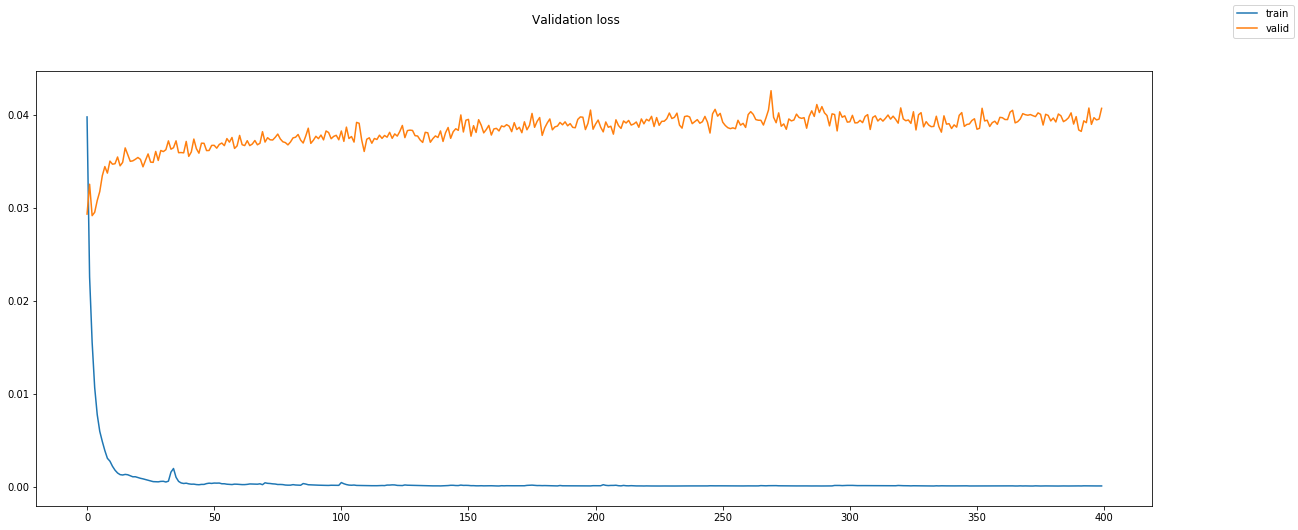

In [37]:
for train_set in train_sets:
    train_set.init()
    train_info = train_set.do_training()
    
    train_info.save(f"info_{train_set.name}.pickle")
    
    # plot loss data
    fig, ax = plt.subplots(figsize=(20, 8))
    ax_train = ax.plot(list(range(train_set.n_epochs)), train_info.train["loss"], label="train")
    ax_valid = ax.plot(list(range(train_set.n_epochs)), train_info.valid["loss"], label="valid")
    fig.legend()
    fig.suptitle("Validation loss")
    plt.show()

## save/load embeddings

In [189]:
def save_vocab_embedding(path, vocab, embedding):
    with open(path, "w") as f:
        for word, vector in tqdm.tqdm(zip(vocab.itos, embedding)):
            
            # skip words with unicode symbols
            if len(word) != len(word.encode()):
                continue
            
            # 'words' like " " or "\n" fail to be loaded
            if word.strip() == "":
                continue

            f.write(f"{word} {' '.join(str(e) for e in vector.tolist())}\n")

In [88]:
def load_context(model, field, path_model, path_vocab, cache_embeddings="cache_embeddings", device=DEVICE):
    _vectors = torchtext.vocab.Vectors(path_vocab, cache_embeddings)  # voir unk_init
    field.build_vocab(data_train, max_size=VOCAB_MAX_SIZE, vectors=_vectors)
    
    model.load_state_dict(torch.load(path_model))
    
    model = model.to(device)
    
    model.embedding.weight.data.copy_(field.vocab.vectors)
    
    iter_train, iter_valid, iter_test = \
        torchtext.data.BucketIterator.splits(datasets=(data_train, data_valid, data_test),
                                             batch_size=BATCH_SIZE,
                                             device=DEVICE,
                                             sort_within_batch=True,
                                             sort_key=lambda example: len(example.input),
                                             sort=False)
    
    return model, (iter_train, iter_valid, iter_test)

In [187]:
save_vocab_embedding("vocab_emb", TEXT.vocab, model.embedding.weight)

50002it [00:09, 5393.37it/s]


In [190]:
model, iters = load_context(default_model(hidden_dim=128, n_layers=3),
                            TEXT,
                            "rnn_hidden-128_nlayers-3.pt",
                            "vocab_emb")
iter_train, iter_valid, iter_test = iters

## Peeking

In [27]:
import spacy

nlp = spacy.load('fr_core_news_sm')

In [28]:
def predict_tokens(tokens, model, device=DEVICE):
    model.eval()
    idxs = [TEXT.vocab.stoi[t] for t in tokens]
    inp = torch.LongTensor(idxs).reshape(-1, 1).to(device)
    output = output_to_pred(model((inp, torch.LongTensor([len(tokens)]))))
    return output.item()


def predict(sentence, model):
    return predict_tokens(list(map(str, nlp.tokenizer(sentence))), model)

In [42]:
model = default_model(hidden_dim=128, n_layers=3)

In [43]:
model.load_state_dict(torch.load('rnn_hidden-128_nlayers-3.pt'))

<All keys matched successfully>

In [44]:
model = model.to(DEVICE)

In [197]:
predict("Du temps perdu.", model), \
predict("Un très bon film, à voir avec toute la famille.", model)

(3.0, 4.0)

In [198]:
for example in random.sample(list(data_train), 3):
    tokens, note = example.input, float(example.target)
    print(" ".join(tokens))
    print(f"true) {note * 5} - {predict_tokens(tokens, model)} (pred")

Oeuvre de réconciliation et d' amour , ce " Pinocchio " suscite des Oh ! et des Ah ! , de notre admiration .
true) 4.0 - 4.5 (pred
Alexeï Guerman a consacré treize années à cette adaptation du roman de science - fiction des frères Strougatski , pour une mise en scène impressionnante . Mais aussi fort dérangeante tant elle malmène le spectateur .
true) 3.0 - 3.5 (pred
Dans cette chronique sombre et kafkaïenne , on lit la rage contenue et la détermination absolue sur le visage rugueux de son acteur , double d’ un réalisateur muselé par la censure .
true) 4.0 - 4.0 (pred


## Testing predictions on extremal marks

Is the model really doing bad if it predicts a 4.5 instead of a 5 ? There are at least two ways to allow for forgivable divergence with the test data :
* decrease notation's granularity, e.g. tranform the marks into good/bad, or good/bad/neutral.
* consider a prediction correct if it belongs to a 'small' interval containing the true value.

### Good/Neutral/Bad prediction

In [93]:
def normalized_to_3_way(pred_tensor, bad_treshold=.375, good_treshold=.625):
    """np array with values: 0: bad, 1: neutral, 2: good"""
    return np.digitize(pred_tensor.cpu().detach().numpy(), [bad_treshold, good_treshold])
    
def eval_accuracy_3w(model, iterator):
    n_examples = 0
    n_success = 0
    for batch in iterator:
        predictions = model(batch.input).squeeze(1)
        n_examples += len(batch)
        n_success += sum(normalized_to_3_way(predictions) == normalized_to_3_way(batch.target))
    return n_success / n_examples

def classif_report_3w(model, iterator):
    def preds_and_trues_to_array(predictions, true_targets):
        return np.concatenate([normalized_to_3_way(true_targets).reshape(-1, 1),
                               normalized_to_3_way(predictions).reshape(-1, 1)], axis=1)
    
    array = None
    for batch in iterator:
        predictions = model(batch.input).squeeze(1)
        
        if array is None:
            array = preds_and_trues_to_array(predictions, batch.target)
        else:
            array = np.concatenate([array,
                                    preds_and_trues_to_array(predictions, batch.target)], axis=0)
    print(sklearn.metrics.classification_report(array[:, 0],
                                                array[:, 1],
                                                labels=[0, 1, 2],
                                                target_names=["bad", "neutral", "good"]))

In [199]:
iterator = iter_test

classif_report_3w(model, iterator)


              precision    recall  f1-score   support

         bad       0.40      0.26      0.32      1713
     neutral       0.66      0.50      0.57      9792
        good       0.66      0.85      0.74     10571

    accuracy                           0.65     22076
   macro avg       0.58      0.54      0.54     22076
weighted avg       0.64      0.65      0.63     22076



### Fuzzy accuracy

In [40]:
def eval_accuracy_fuzzy(model, iterator, fuzziness=.1):
    n_examples = 0.
    n_success = 0.
    for batch in iterator:
        predictions = model(batch.input).squeeze(1)
        n_examples += len(batch)
        n_success += sum(torch.abs(predictions - batch.target) <= fuzziness).item()
    return n_success / n_examples

In [201]:
eval_accuracy_fuzzy(model, iter_test, fuzziness=.2)

0.7527178836745787